# **SAM on brightfield**

Segment anything model on brightfield of Paramecia for shape and area. \
In questo codice vogliamo creare un'interfaccia che elabori le immagini in sequenza (che risulta più semplice e affidabile) ma con un processo automatizzato. In particolare gli step consistono in:

- Caricare tutte le immagini TIF da una cartella
- Selezionare i punti per ogni immagine
- Generare e salvare le maschere risultanti

## **Single tif file code**

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import os
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

path = "z:\\Users\\Benedetta\\3. IF imaging and analysis\\Testing\\"

#Open a tif file
im = Image.open(path+"AED_40x_005.tif")
#im_array = np.array(im.convert("RGB"))


In [58]:
# Convert to numpy array with explicit dtype and ensure it's in the native byte order
im_array_raw = np.asarray(im, dtype=np.float32).copy()  # Create a copy with native byte order

# Print the min and max values to understand the data range
print(f"Original image range: {im_array_raw.min()} to {im_array_raw.max()}")

# Normalize for display (0-1 range for floats)
im_array = (im_array_raw - im_array_raw.min()) / (im_array_raw.max() - im_array_raw.min())

# Get the shape of the array
print(f"Image shape: {im_array_raw.shape}")

""" # Display the normalized image
plt.figure(figsize=(8, 8))
plt.imshow(im_array, cmap='gray')
plt.title("Pixel layout (normalized)")
plt.colorbar(label="Normalized intensity")
plt.show()
 """
# Check if grayscale (1 channel) and convert to RGB (3 channels) for the model
if len(im_array_raw.shape) == 2:
    print("Converting grayscale image to RGB...")
    # For display purposes, normalize to 0-255 range and convert to uint8
    im_array_uint8 = (im_array * 255).astype(np.uint8)
    # Convert grayscale to RGB by repeating the channel 3 times
    im_array_rgb = np.stack([im_array_uint8, im_array_uint8, im_array_uint8], axis=2)
    print(f"RGB image shape: {im_array_rgb.shape}")
elif len(im_array_raw.shape) == 3 and im_array_raw.shape[2] == 1:
    print("Converting single-channel image to RGB...")
    im_array_uint8 = (im_array * 255).astype(np.uint8)
    im_array_rgb = np.concatenate([im_array_uint8, im_array_uint8, im_array_uint8], axis=2)
    print(f"RGB image shape: {im_array_rgb.shape}")
else:
    # Already RGB or multi-channel
    im_array_uint8 = (im_array * 255).astype(np.uint8)
    im_array_rgb = im_array_uint8
    print(f"Using existing multi-channel image: {im_array_rgb.shape}")


#Convert to numpy array
""" im_array = np.array(im)
Get the shape of the array

plt.imshow(im_array, cmap='gray')
plt.title("Pixel layout")
plt.show() """


Original image range: 1136.0 to 3121.0
Image shape: (1024, 1024)
Converting grayscale image to RGB...
RGB image shape: (1024, 1024, 3)


' im_array = np.array(im)\nGet the shape of the array\n\nplt.imshow(im_array, cmap=\'gray\')\nplt.title("Pixel layout")\nplt.show() '

using device: cpu


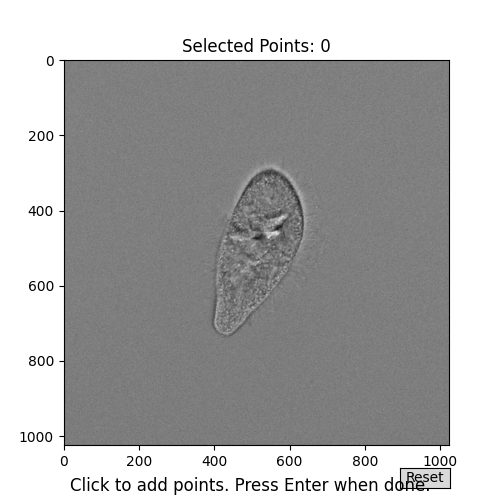

In [59]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")


if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )
sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)
predictor.set_image(im_array_rgb)

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from IPython.display import display, clear_output

# Enable interactive matplotlib widgets in Jupyter
%matplotlib widget

class PointSelector:
    def __init__(self, image):
        self.image = image
        self.points = []
        self.labels = []  # Default label is 1
        self.fig_created = False
        self.setup_figure()
        
    def setup_figure(self):
        # Create figure and display image
        self.fig, self.ax = plt.subplots(figsize=(5, 5))
        self.ax.imshow(self.image)
        
        # Add instruction text
        self.fig.text(0.5, 0.01, 'Click to add points. Press Enter when done.', 
                     ha='center', va='bottom', fontsize=12)
        
        # Connect event handlers
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)
        self.fig.canvas.mpl_connect('key_press_event', self.on_key)
        
        # Add reset button
        ax_reset = plt.axes([0.8, 0.025, 0.1, 0.04])
        self.reset_button = Button(ax_reset, 'Reset')
        self.reset_button.on_clicked(self.reset)
        
        self.ax.set_title(f'Selected Points: {len(self.points)}')
        plt.axis('on')
        self.fig_created = True
        
    def on_click(self, event):
        # Ignore clicks outside the image
        if event.inaxes != self.ax:
            return
            
        # Add the point
        x, y = int(event.xdata), int(event.ydata)
        self.points.append([x, y])
        self.labels.append(1)  # Default label is 1
        
        # Update visualization
        self.show_points()
        
    def on_key(self, event):
        if event.key == 'enter':
            # In Jupyter, we don't want to close the figure
            # Just signal that we're done
            clear_output(wait=True)
            print(f"Selection complete! {len(self.points)} points selected.")
            self.done = True
            
    def reset(self, event):
        self.points = []
        self.labels = []
        self.ax.clear()
        self.ax.imshow(self.image)
        self.ax.set_title(f'Selected Points: {len(self.points)}')
        plt.draw()
            
    def show_points(self):
        # Clear and redraw image
        self.ax.clear()
        self.ax.imshow(self.image)
        
        # Plot points
        points_array = np.array(self.points)
        if len(points_array) > 0:
            self.ax.scatter(
                points_array[:, 0],
                points_array[:, 1],
                color='red',
                marker='*',
                s=200,
                edgecolor='white',
                linewidth=1.25
            )
            
        self.ax.set_title(f'Selected Points: {len(self.points)}')
        plt.draw()
        
    def get_points(self):
        return np.array(self.points), np.array(self.labels)

def show_points(coords, labels, ax):
    """Show points on the image."""
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color='green',
        marker='*',
        s=200,
        edgecolor='white',
        linewidth=1.25
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color='red',
        marker='*',
        s=200,
        edgecolor='white',
        linewidth=1.25
    )

# Example
# Create the point selector
selector = PointSelector(im_array_rgb)

Selected points:
[[487 558]]
Switched to static display mode
torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])
Masks shape: (3, 1024, 1024)


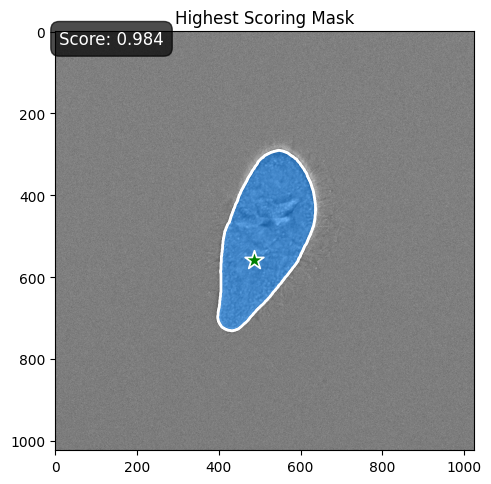

In [60]:
# Get the points after selection (run this cell after selecting points)
input_point, input_label = selector.get_points()
print(f"Selected points:\n{input_point}")

# Close all figures to clean up
plt.close('all')

# Switch to inline mode for static display
%matplotlib inline
print("Switched to static display mode")

# Visualize the final selected points if needed
""" plt.figure(figsize=(5, 5))
plt.imshow(im_array_rgb)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show() """

# Function to show a single mask with score
def show_single_mask(image, mask, score, point_coords=None, point_labels=None):
    """
    Display only the first (highest-scoring) mask with its score
    
    Parameters:
    - image: The original image
    - mask: Single binary mask (H x W)
    - score: Confidence score for the mask
    - point_coords: Optional points to overlay
    - point_labels: Labels for the points
    """
    plt.figure(figsize=(5, 5))
    
    # Display the image
    plt.imshow(image)
    
    # Add mask as a transparent overlay with border
    color = np.array([30/255, 144/255, 255/255, 0.6])  # Light blue, semi-transparent
    h, w = mask.shape[-2:]
    mask_img = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    plt.imshow(mask_img)
    
    # Add contour for the mask boundary
    if mask.sum() > 0:  # Only draw contour if mask is not empty
        contours = plt.contour(mask, 
                             levels=[0.5], 
                             colors=['white'],
                             linewidths=2)
    
    # Add points if provided
    if point_coords is not None and point_labels is not None:
        show_points(point_coords, point_labels, plt.gca())
    
    # Add score as text in the upper left
    plt.annotate(
        f"Score: {score:.3f}",
        (10, 30),
        color='white',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.5", fc="black", alpha=0.7)
    )
    
    plt.title("Highest Scoring Mask")
    plt.tight_layout()
    plt.axis('on')
    plt.show()

# After running your predictor code:
print(predictor._features["image_embed"].shape, predictor._features["image_embed"][-1].shape)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

# Sort masks by score
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

print(f"Masks shape: {masks.shape}")  # (number_of_masks) x H x W

# Display only the first (highest-scoring) mask with its score
show_single_mask(
    image=im_array_rgb, 
    mask=masks[0],  # Just the first mask
    score=scores[0],  # Its corresponding score
    point_coords=input_point, 
    point_labels=input_label
)

## **Generalization to batch of tif files** - fourth try - works!

In [2]:
#Cell 0: Define the base path for images and output
path = "z:\\Users\\Benedetta\\3. IF imaging and analysis\\250514_BF_fixmess\\Tif_data_phem"

In [3]:
# Cell 1: Import libraries and define utility functions
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import os
import cv2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from IPython.display import display, clear_output
from matplotlib.widgets import Button
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg
import ipywidgets as widgets

output_path = os.path.join(path, "masks")
# Create output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Get a list of all TIF files in the directory
image_files = [f for f in os.listdir(path) if f.endswith('.tif')]
print(f"Found {len(image_files)} TIF files in {path}")

# Image and point selection storage
images_data = {}  # Dictionary to store all loaded images and their data

# Function to load and preprocess an image
def load_image(image_path):
    im = Image.open(image_path)
    
    # Convert to numpy array with explicit dtype and ensure it's in the native byte order
    im_array_raw = np.asarray(im, dtype=np.float32).copy() 
    
    # Normalize for display (0-1 range for floats)
    im_array = (im_array_raw - im_array_raw.min()) / (im_array_raw.max() - im_array_raw.min())
    
    # Check if grayscale (1 channel) and convert to RGB (3 channels) for the model
    if len(im_array_raw.shape) == 2:
        # For display purposes, normalize to 0-255 range and convert to uint8
        im_array_uint8 = (im_array * 255).astype(np.uint8)
        # Convert grayscale to RGB by repeating the channel 3 times
        im_array_rgb = np.stack([im_array_uint8, im_array_uint8, im_array_uint8], axis=2)
    elif len(im_array_raw.shape) == 3 and im_array_raw.shape[2] == 1:
        im_array_uint8 = (im_array * 255).astype(np.uint8)
        im_array_rgb = np.concatenate([im_array_uint8, im_array_uint8, im_array_uint8], axis=2)
    else:
        # Already RGB or multi-channel
        im_array_uint8 = (im_array * 255).astype(np.uint8)
        im_array_rgb = im_array_uint8
    
    return im, im_array_rgb, im_array_raw

# Set up visualization functions
def show_mask(mask, ax, random_color=False, borders=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

# Function to show a single mask with score
def show_single_mask(image, mask, score, point_coords=None, point_labels=None):
    """
    Display only the first (highest-scoring) mask with its score
    
    Parameters:
    - image: The original image
    - mask: Single binary mask (H x W)
    - score: Confidence score for the mask
    - point_coords: Optional points to overlay
    - point_labels: Labels for the points
    """
    fig = plt.figure(figsize=(5, 5))
    
    # Display the image
    plt.imshow(image)
    
    # Add mask as a transparent overlay with border
    color = np.array([30/255, 144/255, 255/255, 0.6])  # Light blue, semi-transparent
    h, w = mask.shape[-2:]
    mask_img = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    plt.imshow(mask_img)
    
    # Add contour for the mask boundary
    if mask.sum() > 0:  # Only draw contour if mask is not empty
        contours = plt.contour(mask, 
                             levels=[0.5], 
                             colors=['white'],
                             linewidths=2)
    
    # Add points if provided
    if point_coords is not None and point_labels is not None:
        show_points(point_coords, point_labels, plt.gca())
    
    # Add score as text in the upper left
    plt.annotate(
        f"Score: {score:.3f}",
        (10, 30),
        color='white',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.5", fc="black", alpha=0.7)
    )
    
    plt.title("Highest Scoring Mask")
    plt.tight_layout()
    plt.axis('on')
    
    return fig

class PointSelector:
    def __init__(self, image, image_name, fig_size=(5, 5)):
        self.image = image
        self.image_name = image_name
        self.points = []
        self.labels = []  # Default label is 1
        self.fig_size = fig_size
        self.fig = None
        self.ax = None
        self.active = False
        
    def setup_figure(self):
        # Create figure and display image
        self.fig, self.ax = plt.subplots(figsize=self.fig_size)
        self.ax.imshow(self.image)
        
        # Add instruction text
        self.fig.text(0.5, 0.01, 'Click to add foreground points. Alt+click for background points.', 
                     ha='center', va='bottom', fontsize=9)
        
        # Connect event handlers
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)
        
        # Add reset button
        ax_reset = plt.axes([0.8, 0.025, 0.1, 0.04])
        self.reset_button = Button(ax_reset, 'Reset')
        self.reset_button.on_clicked(self.reset)
        
        self.ax.set_title(f'{self.image_name} | Points: {len(self.points)}')
        plt.axis('on')
        self.active = True
        
    def on_click(self, event):
        # Ignore clicks outside the image
        if self.active and event.inaxes == self.ax:
            # Add the point
            x, y = int(event.xdata), int(event.ydata)
            self.points.append([x, y])
            
            # Check if Alt key is pressed for background points
            if event.key == 'alt':
                self.labels.append(0)  # Background point
            else:
                self.labels.append(1)  # Foreground point
            
            # Update visualization
            self.show_points()
            
            # Update the stored data
            if self.image_name in images_data:
                images_data[self.image_name]['points'] = np.array(self.points) if self.points else np.zeros((0, 2))
                images_data[self.image_name]['labels'] = np.array(self.labels) if self.labels else np.zeros(0)
    
    def reset(self, event):
        self.points = []
        self.labels = []
        self.ax.clear()
        self.ax.imshow(self.image)
        self.ax.set_title(f'{self.image_name} | Points: {len(self.points)}')
        plt.draw()
        
        # Update the stored data
        if self.image_name in images_data:
            images_data[self.image_name]['points'] = np.array([])
            images_data[self.image_name]['labels'] = np.array([])
            
    def show_points(self):
        # Clear and redraw image
        self.ax.clear()
        self.ax.imshow(self.image)
        
        # Plot points - green for foreground, red for background
        if len(self.points) > 0:
            points_array = np.array(self.points)
            labels_array = np.array(self.labels)
            
            # Handle foreground points
            fg_points = points_array[labels_array==1] if len(points_array[labels_array==1]) > 0 else np.empty((0, 2))
            if len(fg_points) > 0:
                self.ax.scatter(
                    fg_points[:, 0],
                    fg_points[:, 1],
                    color='green',
                    marker='*',
                    s=200,
                    edgecolor='white',
                    linewidth=1.25
                )
            
            # Handle background points
            bg_points = points_array[labels_array==0] if len(points_array[labels_array==0]) > 0 else np.empty((0, 2))
            if len(bg_points) > 0:
                self.ax.scatter(
                    bg_points[:, 0],
                    bg_points[:, 1],
                    color='red',
                    marker='*',
                    s=200,
                    edgecolor='white',
                    linewidth=1.25
                )
            
        self.ax.set_title(f'{self.image_name} | Points: {len(self.points)}')
        plt.draw()
        
    def get_points(self):
        return np.array(self.points) if self.points else np.zeros((0, 2)), np.array(self.labels) if self.labels else np.zeros(0)

Found 6 TIF files in z:\Users\Benedetta\3. IF imaging and analysis\250514_BF_fixmess\Tif_data_phem


In [4]:
# Cell 2: Set up the SAM2 model
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Configure device-specific settings
if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

# Load the SAM2 model
sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

# Set random seed for reproducibility
np.random.seed(3)

Using device: cpu


Will process 6 images
Loading: PHEMfix_Calcium_023.tif
Loading: PHEMfix_Control_007.tif
Loading: PHEMfix_Calcium_003.tif
Loading: PHEMfix_Control_006.tif
Loading: PHEMfix_Control_012.tif
Loading: PHEMfix_Control_011.tif

All images loaded! Select points for each image by clicking on them.
Use Alt+click to add background points (red). Regular click for foreground points (green).
When you're done selecting points for all images, run the next cell to process them.


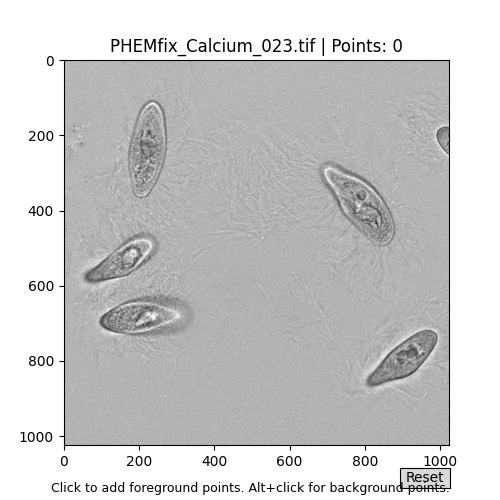

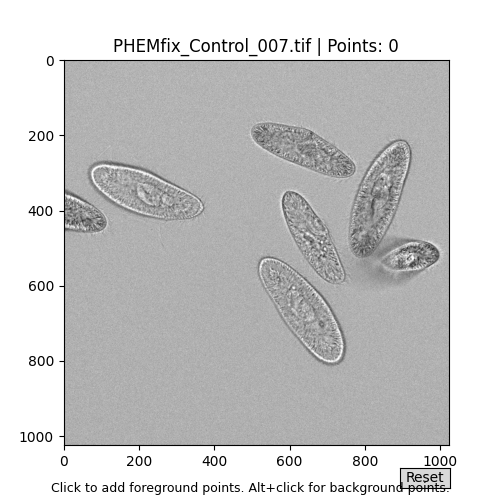

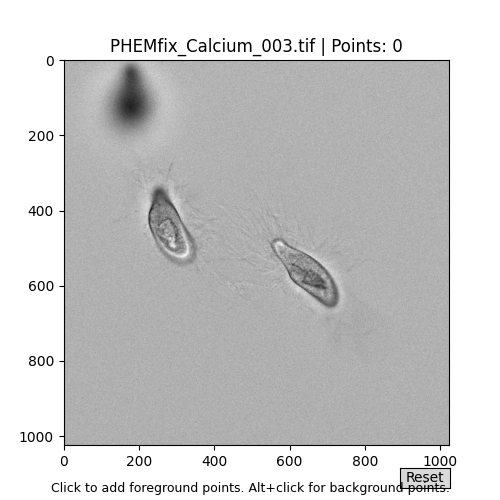

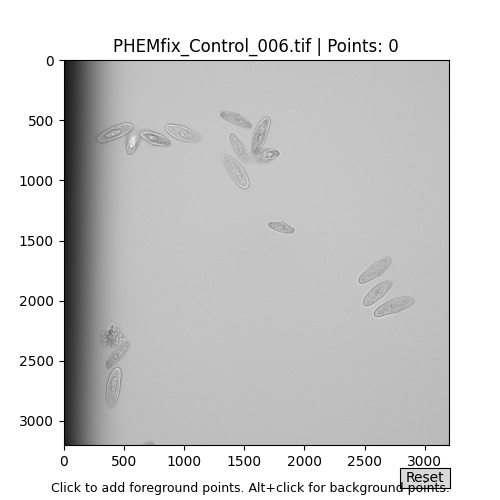

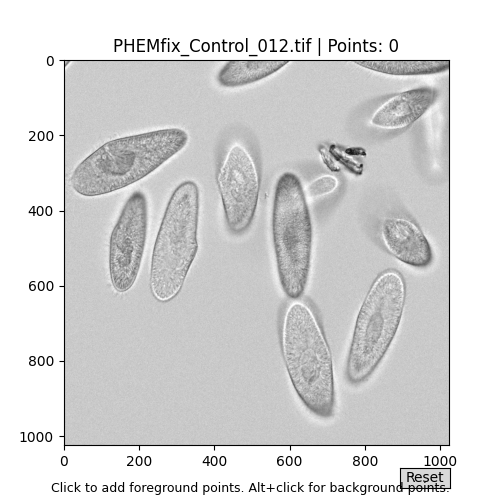

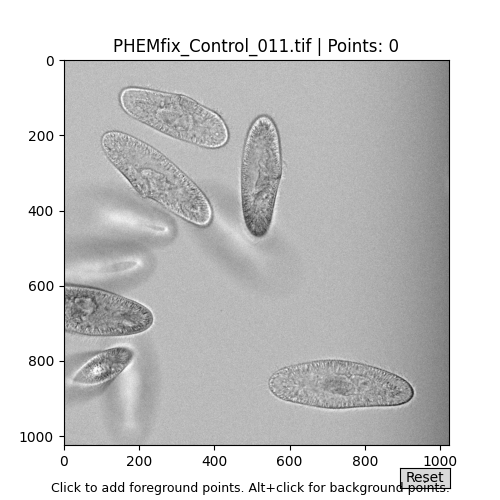

In [5]:
# Cell 3: Load all images and create interactive point selection widgets
# This will load all images and display them in a single cell for point selection

# First, limit the number of images to process (for testing)
# Change this number as needed
max_images = None  # Set to None to process all images
image_files_to_process = image_files[:max_images] if max_images is not None else image_files
print(f"Will process {len(image_files_to_process)} images")

# Enable interactive matplotlib widgets in Jupyter
%matplotlib widget

#Increase the maximum figure warning limit
import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = 50  # Increase this value based on your needs

# Load all images
for img_filename in image_files_to_process:
    full_path = os.path.join(path, img_filename)
    print(f"Loading: {img_filename}")
    
    # Load and preprocess the image
    original_img, processed_img, raw_img = load_image(full_path)
    
    # Store the image data
    images_data[img_filename] = {
        'original': original_img,
        'processed': processed_img,
        'raw': raw_img,
        'points': np.zeros((0, 2)),
        'labels': np.zeros(0),
        'selector': None
    }
    
    # Create a point selector for this image
    selector = PointSelector(processed_img, img_filename)
    images_data[img_filename]['selector'] = selector
    
    # Setup the figure for this image
    selector.setup_figure()
    
print("\nAll images loaded! Select points for each image by clicking on them.")
print("Use Alt+click to add background points (red). Regular click for foreground points (green).")
print("When you're done selecting points for all images, run the next cell to process them.")

In [6]:
# Cell 4: Process all images with SAM2 and save masks
# This will process all images and save the masks

# Switch to inline mode for static display
%matplotlib inline
print("Processing all images...")

# Process each image
for img_filename, data in images_data.items():
    print(f"\nProcessing: {img_filename}")
    
    # Get the points and labels
    input_point = data['points']
    input_label = data['labels']
    
    # Skip if no points were selected
    if len(input_point) == 0:
        print(f"No points selected for {img_filename}, skipping")
        continue
    
    # Set the image in the predictor
    predictor.set_image(data['processed'])
    
    # Predict masks
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    
    # Sort masks by score
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    
    # Store results
    data['masks'] = masks
    data['scores'] = scores
    
    print(f"Generated {len(masks)} masks, top score: {scores[0]:.3f}")
    
    """ # Show the highest-scoring mask
    if len(masks) > 0:
        mask_fig = show_single_mask(
            image=data['processed'],
            mask=masks[0],
            score=scores[0],
            point_coords=input_point,
            point_labels=input_label
        )
        plt.close(mask_fig)  # Close after display to avoid cluttering
    else:
        print("No masks generated") """

print("\nAll images processed!")

Processing all images...

Processing: PHEMfix_Calcium_023.tif
Generated 3 masks, top score: 0.913

Processing: PHEMfix_Control_007.tif
Generated 3 masks, top score: 0.797

Processing: PHEMfix_Calcium_003.tif
No points selected for PHEMfix_Calcium_003.tif, skipping

Processing: PHEMfix_Control_006.tif
Generated 3 masks, top score: 0.649

Processing: PHEMfix_Control_012.tif
Generated 3 masks, top score: 0.979

Processing: PHEMfix_Control_011.tif
Generated 3 masks, top score: 0.800

All images processed!


In [7]:
# Cell 5: Save all masks to files with preserved calibration metadata
# This will save all generated masks to the output directory while preserving calibration info

import tifffile

saved_count = 0
for img_filename, data in images_data.items():
    # Skip if no masks were generated
    if 'masks' not in data or len(data['masks']) == 0:
        print(f"No masks to save for {img_filename}")
        continue
    
    # Get the highest-scoring mask
    mask = data['masks'][0]
    
    # Prepare output filename
    base_name = os.path.splitext(img_filename)[0]
    mask_filename = f"{base_name}_mask.tif"
    mask_path = os.path.join(output_path, mask_filename)
    
    # Convert mask to binary format (uint8 where 255 is the mask)
    binary_mask = (mask * 255).astype(np.uint8)
    
    # Method 1: Use tifffile to preserve metadata
    # First, read the original file with tifffile to extract all metadata
    original_path = os.path.join(path, img_filename)
    
    try:
        # Load the original image using tifffile to access its metadata
        with tifffile.TiffFile(original_path) as tif:
            metadata = {}
            
            # Get resolution and other important tags
            for tag in tif.pages[0].tags.values():
                if tag.name in ('XResolution', 'YResolution', 'ResolutionUnit', 
                                'ImageDescription', 'Software', 'DocumentName'):
                    metadata[tag.name] = tag.value
                    
            # Extract ImageJ metadata if present
            if hasattr(tif, 'imagej_metadata') and tif.imagej_metadata is not None:
                ij_metadata = tif.imagej_metadata
            else:
                ij_metadata = None
                
            # Save the mask with the metadata
            tifffile.imwrite(
                mask_path,
                binary_mask,
                metadata=metadata,
                imagej=ij_metadata is not None,
                resolution=(
                    metadata.get('XResolution', (1, 1)),
                    metadata.get('YResolution', (1, 1))
                ),
                resolutionunit=metadata.get('ResolutionUnit', 1)
            )
            
            print(f"Saved mask with calibration data: {mask_filename}")
            saved_count += 1
            
    except Exception as e:
        # Fallback to basic saving without metadata if tifffile fails
        print(f"Error preserving metadata for {img_filename}: {e}")
        print("Saving mask without calibration data...")
        
        # Save using PIL as a basic TIF
        mask_img = Image.fromarray(binary_mask)
        mask_img.save(mask_path)
        saved_count += 1
    
print(f"\nSaved {saved_count} masks to {output_path}")
## Disclaimer: the maskss are saved correctly, but when opening them in ImageJ, you might need to adjust the display settings to visualize them correctly.

Saved mask with calibration data: PHEMfix_Calcium_023_mask.tif
Saved mask with calibration data: PHEMfix_Control_007_mask.tif
No masks to save for PHEMfix_Calcium_003.tif
Saved mask with calibration data: PHEMfix_Control_006_mask.tif
Saved mask with calibration data: PHEMfix_Control_012_mask.tif
Saved mask with calibration data: PHEMfix_Control_011_mask.tif

Saved 5 masks to z:\Users\Benedetta\3. IF imaging and analysis\250514_BF_fixmess\Tif_data_phem\masks


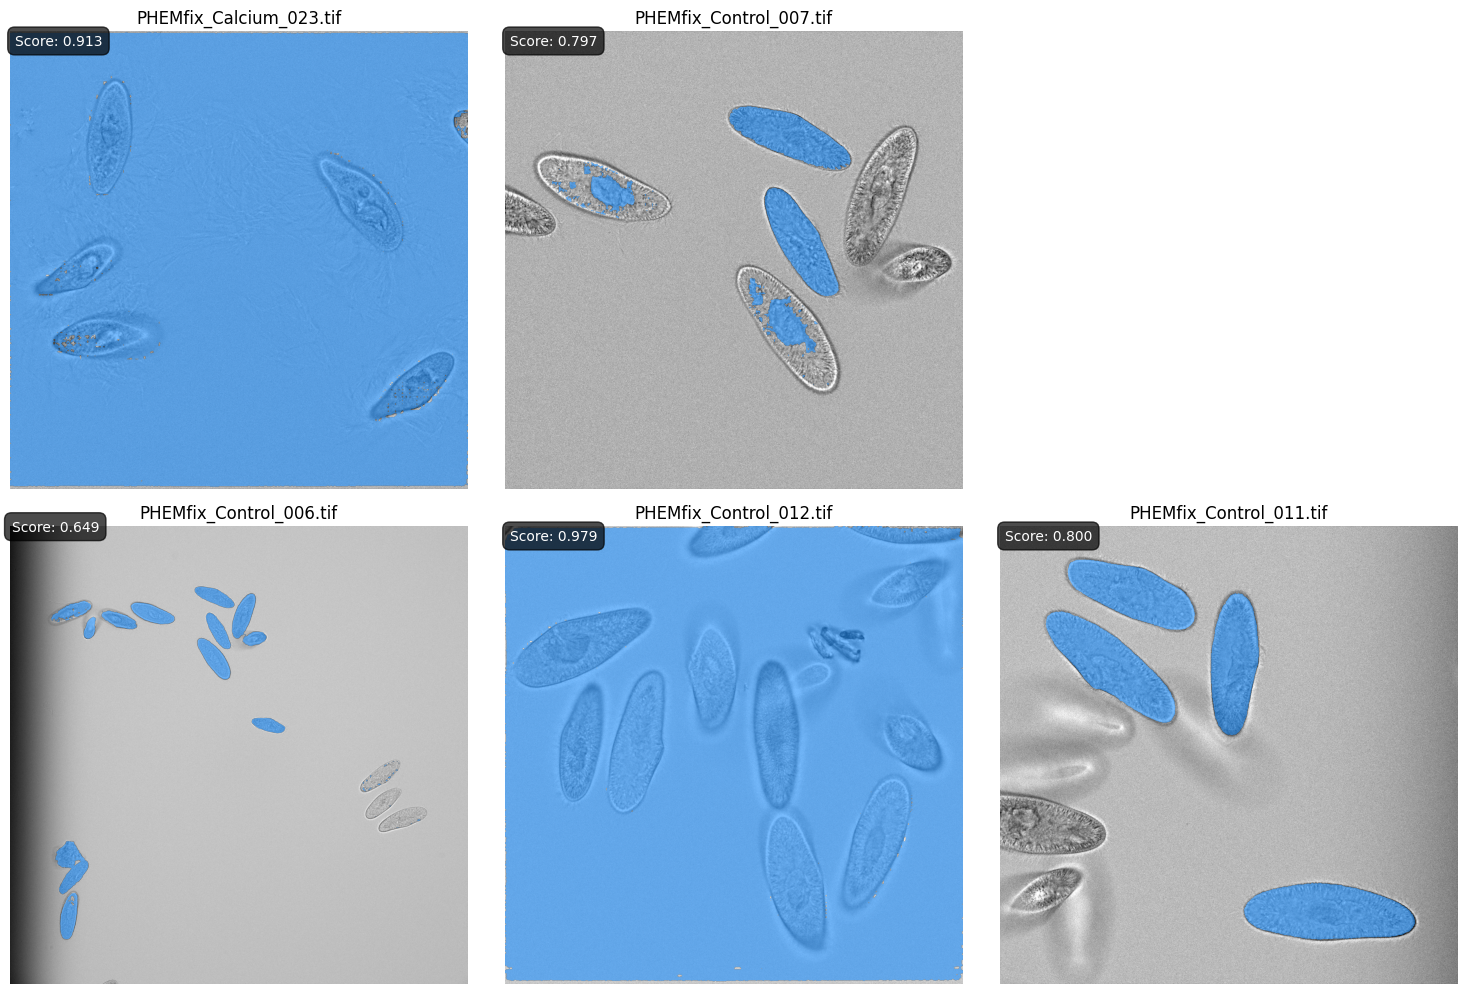

Done! All masks have been generated and saved.


In [ ]:
# Cell 6 (optional): Show summary of results
# This will generate a summary visualization of all processed images
#run twice for a correct visualization
plt.figure(figsize=(15, 5 * (len(images_data) // 3 + 1)))

for i, (img_filename, data) in enumerate(images_data.items()):
    if 'masks' not in data or len(data['masks']) == 0:
        continue
        
    plt.subplot(len(images_data) // 3 + 1, 3, i + 1)
    
    # Display the image
    plt.imshow(data['processed'])
    
    # Add mask as a transparent overlay
    mask = data['masks'][0]
    score = data['scores'][0]
    
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_img = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    plt.imshow(mask_img)
    
    # Add score as text
    plt.annotate(
        f"Score: {score:.3f}",
        (10, 30),
        color='white',
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", fc="black", alpha=0.7)
    )
    
    plt.title(img_filename)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

print("Done! All masks have been generated and saved.")